(vancouver_visible)=
# NDVI for Vancouver

* One of the most important MODIS level 2 products for land remote sensing is the
  [Normalized difference vegetation index](https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index)

* Visible red (channel 1) and nearir (Channel 2) reflectivities at 250 meter resolution

* Since 250 meter resolution channels are so big, this notebook reads a subset
  of a Vancouver scene.  Channel 1 and Channel 2 are stored as 1 dimensional vectors,
  since all we are doing here is histogramming.  No need for pyresample or lats/lons.

* [Modis channel listing](https://modis.gsfc.nasa.gov/about/specifications.php)

* Band 1 centered at 0.645 microns (red), Band 2 at 0.85 microns (nearir)

* data acquired at 250 m resolution, August 11, 2016

* I've written the measurements between -125 -> -120 deg lon and 45-50 degrees lat to
  an hdf:  vancouver_hires.h5, download in the cell below

* see what the  [ndvi](https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index) histogram looks like at 250 meter resoluiton

In [1]:
import numpy as np
import h5py
import sys
import a301_lib
import matplotlib
from matplotlib import pyplot as plt
import sat_lib.hdftools.h5dump as h5dump
from sat_lib.modismeta_read import parseMeta
from sat_lib.geometry import get_proj_params
import cartopy

#
# use hdfview to see the structure of this file
#
filename = a301_lib.sat_data / 'vancouver_hires.h5'

******************************
context imported. Front of path:
/home/phil/work

in sat_lib init


In [2]:
h5dump.main(filename)

opening /home/phil/work/sat_data/vancouver_hires.h5
++++++++++++++++++++
found the following top-level items: 
data_fields: <HDF5 group "/data_fields" (2 members)>
latlon: <HDF5 group "/latlon" (2 members)>
++++++++++++++++++++
_______________
root group object <HDF5 group "/data_fields" (2 members)>
_______________
member of group: /data_fields: <HDF5 dataset "chan1": shape (2469, 715), type "<f4">
    descrip: MODIS chan1 reflectivity at 250 meter resolution
member of group: /data_fields: <HDF5 dataset "chan2": shape (2469, 715), type "<f4">
    descrip: MODIS chan2 reflectivity at 250 meter resolution
_______________
root group object <HDF5 group "/latlon" (2 members)>
_______________
member of group: /latlon: <HDF5 dataset "lat": shape (2469, 715), type "<f4">
    descrip: latitude, degrees N
member of group: /latlon: <HDF5 dataset "lon": shape (2469, 715), type "<f4">
    descrip: longitude, degrees E
-------------------
attributes for the root file
-------------------
attribute n

Here is the corresponding red,green,blue color composite for the granule.

<img src='figures/MYBRGB.A2016224.2100.006.2016237025650.jpg' width='600px' >

## Histogram

Now histogram the NDVI for the Vancouver box -- note the range of NDVI -- lots of vegetation (0.8) and some water (less than 0)

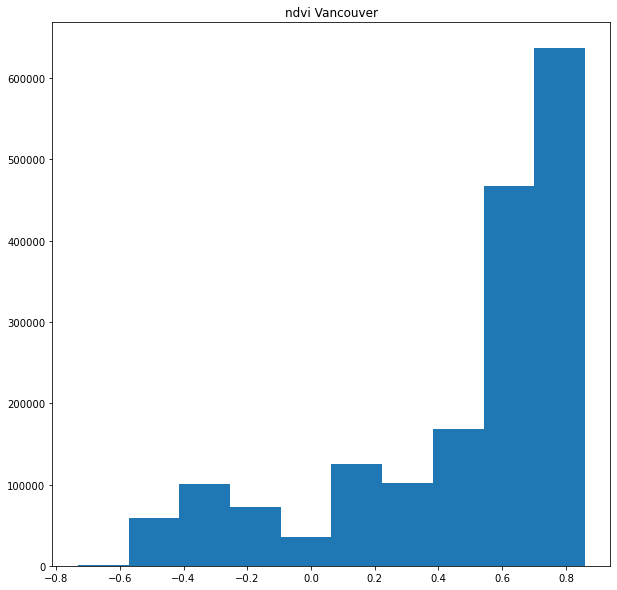

In [3]:
with h5py.File(filename,'r') as h5_file:
    chan1_refl=h5_file['data_fields']['chan1'][...]
    chan2_refl=h5_file['data_fields']['chan2'][...]
    lats=h5_file['latlon']['lat'][...]
    lons=h5_file['latlon']['lon'][...]
    lat_0 = h5_file.attrs['lat_0']
    lon_0 = h5_file.attrs['lon_0']
    core_metadata = h5_file.attrs['CoreMetadata.0']
ndvi = (chan2_refl - chan1_refl)/(chan2_refl + chan1_refl)
#breakpoint()
fig, axis = plt.subplots(1,1,figsize=(10,10))
axis.hist(ndvi.flat)
axis.set(title='ndvi Vancouver');

## Resample

* Now resample following https://a301_web.eoas.ubc.ca/week4/cartopy_resample_ch30_h5.html?highlight=resample#now-resample

One complication is that my central `lat_0` and `lon_0` are not the same as given by swath info,
because I am using only a slice from the large QKM file.  So I need to replace those
with the values I read from `vancouver_hires.h5` at the top of the notebook.

In [4]:
swath_info = parseMeta(core_metadata)
proj_params = get_proj_params(swath_info)
proj_params['lon_0'] = lon_0
proj_params['lat_0'] = lat_0
#breakpoint()

In [5]:
from pyresample import SwathDefinition, kd_tree, geometry

swath_def = SwathDefinition(lons, lats)
area_def= swath_def.compute_optimal_bb_area(proj_dict=proj_params)
fill_value = -9999.0
ndvi_reproj = kd_tree.resample_nearest(
    swath_def,
    ndvi.ravel(),
    area_def,
    radius_of_influence=5000,
    nprocs=2,
    fill_value=fill_value,
)
ndvi_reproj[ndvi_reproj < -9000] = np.nan
print(f"\ndump area definition:\n{area_def}\n")
print(
    (
        f"\nx and y pixel dimensions in meters:"
        f"\n{area_def.pixel_size_x}\n{area_def.pixel_size_y}\n"
    )
)

/home/phil/mini38/envs/work/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()



dump area definition:
Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'lat_0': '47.4990692138672', 'lon_0': '-122.728500366211', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 815
Number of rows: 2715
Area extent: (-168985.7322, -318688.8663, 185785.2168, 323362.0794)


x and y pixel dimensions in meters:
435.3017778720044
236.4828529225044



/home/phil/mini38/envs/work/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [6]:
import copy
pal = plt.get_cmap("Greens")
pal = copy.copy(pal)
pal.set_bad("0.75")  # 75% grey for out-of-map cells
pal.set_over("r")  # color cells > vmax red
pal.set_under("k")  # color cells < vmin black
vmin = 0
vmax = 0.8
from matplotlib.colors import Normalize

the_norm = Normalize(vmin=vmin, vmax=vmax, clip=False)

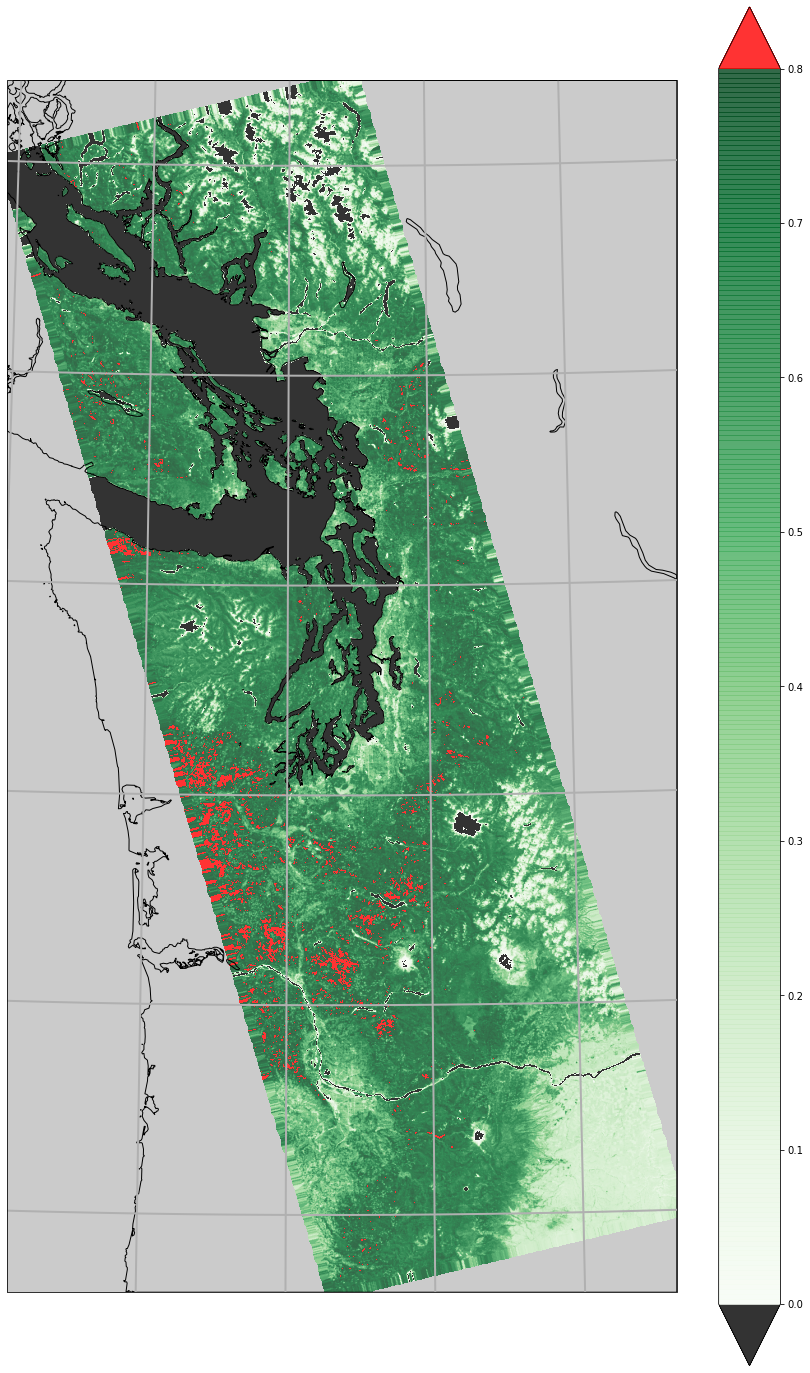

In [7]:
crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(1, 1, figsize=(15,25), subplot_kw={"projection": crs})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="high", levels=[1, 2, 3]))
ax.set_extent(crs.bounds, crs)
cs = ax.imshow(
    ndvi_reproj,
    transform=crs,
    extent=crs.bounds,
    origin="upper",
    alpha=0.8,
    cmap=pal,
    norm=the_norm,
)
fig.colorbar(cs, extend="both");
fig.savefig('figures/vancouver.png')

<img src='figures/vancouver.png'>